# Model Designation

This use case belongs to the class of supervised non-probabilistic classical machine learning regression task. 
Let melaborate this.
- Supervised means that it is possible to evaluate the performance of a model on the basis of comparison between reference and prediction. Therefore, it is possible to use objective measurement for the purposes of model testing and subsequent continuous evaluation of model performance in production.
- Non-probabilistinc means that the model does not provide neither (a) uncertainity estimate nor (b) posibility to integrate prior knowledge into a modeling process.
- Classical machine learning (ML) means that the selection of models is limited to linear and non-linear models with the exception of deep artifical neural networks (ANN). Typical representatives of classical machine learning models are: linear regression, tree-based models, Support Vector Machines, etc.
- Regression means that the objective of model is to predict a continuos variable.

# Objective of Learning Task

The objective is to reconstruct the original content of the data set. For the purposes of this demonstration, a selection of grayscale images will be utilized to form a dataset, which content will be reconstucted, after removal one-half of its content. Therefore, one half of the image will assume the role of the features, and another half of the image will assume the role of the targets.

# Technology Stack

Python has been selected for the purposes of model development. Virtualenv package is utilized for generation of specific environments. Scikit-learn is the package for ML models and aditional functinalities, while the low level API for numerical computation is Intel Math Kernel Library (MKL). Data manitpulation is mostly done in numpy because there is there is no pronunced need to use labeled feature and target vectors. Therefore, it is necesary to use these techonogies in order to obtain reproducibility as well as sucessful execution of modeling tasks. 

# Methodology of Model Training and Testing

This modeling process follows basic methodology of model training and testing.
- The data set is split to trainin and testing set of equal sizes.
- Selection of classic ML models is fit to the training set, and their performance is recorded.
- Each of these models is then fit to the testing set, and the performance on testing set is recorded as well.

Design choices regarding selection of initial training parameters are based on common sense and minimal pre-testing. No hyper-parameter tuning is performed. No cross validation is performed neither.

Reasoning behind such a simplistic approach to model training and testing is driven by limitations of the model development environment, especially in the terms of computational resources. Therefore, methodology of model training and testing is designed to meet the requirements of fast development and low computational effort, rather than designed to find best solution in terms of its generalization ability and accuracy.
Model training and testing proces would greatly benefit from introduction of hyper-parameter tuning and cross validation.

However, even in the presence of such trade-offs model development process was still able to deliver valid outcomes, and can serve as a solid foundation which can be extended in order to improve its performance and robustness. The underlying process is also valid and can be utilized for solving other ML tasks, which is another benefit.

# Model Development

Let us start with defining importing necessary libaries or specific functions.

In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
from math import floor, ceil
from matplotlib.gridspec import GridSpec
from matplotlib import pyplot as plt
import datetime
from itertools import product
from joblib import dump, load
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    MultiTaskLasso,
    MultiTaskElasticNet,
    Lars,
    OrthogonalMatchingPursuit
)
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import RadiusNeighborsRegressor, KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic
from scipy.stats import pearsonr

c:\environments\standard_mkl_notebook\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Fistly, we will define a function which reads the names of all files within specified directory.

In [2]:
def get_all_files_within_folder(path):
    """
    Return a list wh. all files within a folder specified in path.
    """
    return [
        file for file in os.listdir(path) if os.path.isfile(
            os.path.join(path, file)
        )
    ]

Then, we will define a function whic reads all image files within specified direcory, resizes them to desired size, and converts them to grayscale. Function returns a numpy array with flattened images. Each image is stored in exactly one row of numpy array.

In [3]:
def get_images(path):
    """
    Return data frame with images loaded from a folder designated
    in path. Resize, convert to gray-scale, and flatten the images.
    """
    # Get names of image files.
    image_file_names = get_all_files_within_folder(path=path)
    # Set working directory.
    os.chdir(path)
    # Iterate over files and load images.
    for image in enumerate(image_file_names):
        print('Getting data for image: %s' % (str(image[0])))
        # Get image from file.
        image_array = Image.open(image[1])
        # Resize image
        resized_image = resize_image_according_to_width(
            inn=image_array,
            proportion=.5
        )
        # Convert to gray-scale.
        image_gray = resized_image.convert('L')
        # Flatten.
        flattened_image = np.array(image_gray).reshape(-1)
        # On first pass place into a matrix.
        if image[0] == 0:
            out = np.matrix(flattened_image)
        # On all other passes concatenate with pre-existing matrix.
        else:
            out = np.vstack([out, flattened_image])
    return out

Even though not strictly needed, cropping function is supplied as well.

In [4]:
def crop_image(inn, horizontal_proportion, vertical_proportion):
    """
    Return cropped image.
    """
    # Get height and width of input image.
    height, width = np.shape(inn)[0], np.shape(inn)[1]
    # Declare dimensions of the area which will remain after cropping.
    left = int(floor(width*horizontal_proportion))
    upper = int(floor(height*vertical_proportion))
    right = width - left
    lower = height - upper
    # Return cropped image.
    return inn.crop((left, upper, right, lower))

Finally, a function for resizing is added.

In [5]:
def resize_image_according_to_width(inn, proportion):
    """
    Return resized image.
    """
    # Get width of input image.
    width = np.shape(inn)[1]
    # Resized dimesions.
    resized_width = int(floor(width*proportion))
    resized_height = int(floor(np.shape(inn)[0]*proportion))
    return inn.resize((resized_width, resized_height), Image.ANTIALIAS)

After defining functions for manupulation with images, we are switching to functions related to execution of machine learning tasks.

The first in line is function for reshuffling of the data set.

In [6]:
def shuffle_data_set(inn):
    """
    Return shuffled data set.
    """
    np.random.seed(928)
    shuffled_indices = np.random.permutation(len(inn))
    return inn[shuffled_indices]

A function to separate training and tesitng set follows.

In [7]:
def separate_training_and_testing_set(inn, proportion):
    """
    Return training and testing from inn data set divided in desired
    proportion.
    """
    row_for_division = int(ceil(np.shape(inn)[0]*proportion))
    return \
        inn[0:row_for_division],\
        inn[row_for_division:np.shape(inn)[0]]

Function which separates features (sections of images which is preserved) and targets (sections of images which are to be reconstructed) is quick to follow.

In [8]:
def separate_features_from_targets(inn, proportion):
    """
    Return separated features and targets according to the desired
    proportion.
    """
    column_for_division = int(ceil(np.shape(inn)[1]*proportion))
    return \
        inn[:, 0:column_for_division],\
        inn[:, column_for_division:np.shape(inn)[1]]

This brings to an end the set of functions for manipulation with data, and we start with the functions for instantiation of machine learning models. In vocabulary of scikit learn machine learning model is designated as "estimator".

In [9]:
def declare_estimator(desired_estimator):
    """
    Return an instance of desired estimator.
    """
    if desired_estimator == 'linear_regression':
        out = LinearRegression()
    elif desired_estimator == 'ridge':
        out = Ridge()
    elif desired_estimator == 'lasso':
        out = MultiTaskLasso(
            alpha=.5, normalize=True, max_iter=100, tol=1e-3
        )
    elif desired_estimator == 'elastic_net':
        out = MultiTaskElasticNet(
            alpha=.5, normalize=True, max_iter=100, tol=1e-3
        )
    elif desired_estimator == 'lars':
        out = Lars(verbose=True, normalize=True)
    elif desired_estimator == 'orthogonal_matching_pursuit':
        out = OrthogonalMatchingPursuit()
    elif desired_estimator == 'kernel_ridge':
        out = KernelRidge()
    elif desired_estimator == 'radius_neighbors':
        out = RadiusNeighborsRegressor(radius=128, leaf_size=2000, n_jobs=-1)
    elif desired_estimator == 'k_neighbors':
        out = KNeighborsRegressor()
    elif desired_estimator == 'gaussian_process':
        out = GaussianProcessRegressor(
            normalize_y=True, kernel=RationalQuadratic()
        )
    elif desired_estimator == 'decision_tree':
        out = DecisionTreeRegressor()
    elif desired_estimator == 'extra_trees':
        out = ExtraTreesRegressor()
    elif desired_estimator == 'random_forest':
        out = RandomForestRegressor(n_jobs=-1)
    return out

Let us briefly elaborate this selection of ML models. What would be a key feature that is common to all of these models? Common feature of all selected models is that they are able to give multi-output predictions. In contrast to single-output models such as SVMs, these models inherently can predict multiple values. Their target has the shape [samples, targets]. Sklearn provides this cabability to estimators which are not inherently able to operate in this manner, via sklearn.multioutput.MultiOutputRegressor object.

However, it was also important to use estimators which can be trained in short amount of time. Therefore, majority of the estimators listed above belong to the class of linear models, with addition of couple non-linear but still fast models such as tree-based models.

After declaring estimators, it is necessary to establish metrics for evaluation of model performance. For the purposes of this model development process the choince was made to use Mean Absolute Error and squared Pearson correlation coefficient.

This function computes MAE.

In [10]:
def compute_mae(observations, outcome):
    """
    Return Mean Absolute Error.
    """
    return np.sum(np.mean(np.abs(observations-outcome), axis=0))

And this function computes squared Pearson correlation coefficient.

In [11]:
def compute_squared_pearson_r(observations, outcome):
    """
    Return mean squared Pearson R for all vectors inside input matrices.
    """
    # Declare a list to store Pearson correlation coefficient.
    pearson_r = []
    # Iterate over columns, compute coefficient and append to list.
    for vectors in range(0, np.shape(observations)[1]):
        pearson_r.append(pearsonr(
                x=observations[:, vectors],
                y=outcome[:, vectors]
            )[0])
    # Covert the list to an array.
    pearson_r = np.array(pearson_r)
    # Drop NaNs which occur because SDD can be zero for some columns.
    pearson_r = pearson_r[np.logical_not(np.isnan(pearson_r))]
    # After removal o NaNs square and reduce to mean.
    return np.mean(np.power(pearson_r, 2))


This function requires some elaboration. Namely since computation of Pearson correlation coefficient requires division by standard deviation, all variables which have standard deviation equal to zero have to be removed. That is why there is intemediate preprocessng step which solves this issue before raising the vector with PCC to power of two and computing its mean.

We also need a function which will save the predictions which contain reconstructed data sets for later processing. Saving is facilitated with the usage of HDF file format. This funcionality is of considerate value and importance in the case of lengthy trining processes, because it allows examination of results independent of model training. 

In [12]:
def save_reconstruction(file_name, base, reconstruction):
    """
    Save reconstruction to the HDF file.
    """
    out = np.hstack([base, reconstruction])
    out = out * 255
    out = pd.DataFrame(out)
    out.to_hdf(file_name, key='reconstruction')

Finally, we have the workhorse of the enire training process. A function whic sequentially executes (a) model training, (b) evaluates performance in testing, (b) executes model testing, and (d) evaluates the performance in thesing.

Apart from these main function it facilitates, it also keeps recod of model performance, saves reconstructed files, saves models as joblib dumps, measures duration of training for each model, and provides logg messages.

It is top level adminstrator of the enire training proces, rounded of with try/except clause to ensure continuation of the training process even in the presence of errors.

In [13]:
def execute_training_process(models,
                             model_storage,
                             predictions_storage,
                             features_for_training,
                             features_for_testing,
                             targets_for_training,
                             targets_for_testing):
    """
    Execute model training process and return training process summary.
    """
    # Declare an empty list for summary of training process.
    summary_of_training_process = []
    # Iterate over estimators and train and test estimators.
    for estimator in models:
        try:
            model = declare_estimator(desired_estimator=estimator)
            training_start = datetime.datetime.now()
            model.fit(X=features_for_training, y=targets_for_training)
            training_end = datetime.datetime.now()
            total_training_duration = str(training_end - training_start)
            predictions_in_training = model.predict(X=features_for_training)
            mae_training = compute_mae(
                observations=targets_for_training,
                outcome=predictions_in_training
            )
            r_squared_training = compute_squared_pearson_r(
                observations=targets_for_training,
                outcome=predictions_in_training
            )
            print(
                'Training: %s. MAE (Sum): %s, R2 (Mean): %s' % (
                    estimator,
                    mae_training,
                    r_squared_training,
                )
            )
            predictions_in_testing = model.predict(X=features_for_testing)
            mae_testing = compute_mae(
                observations=targets_for_testing,
                outcome=predictions_in_testing
            )
            r_squared_testing = compute_squared_pearson_r(
                observations=targets_for_testing,
                outcome=predictions_in_testing
            )
            print(
                'Testing: %s. MAE (Sum): %s, R2 (Mean): %s' % (
                    estimator,
                    mae_testing,
                    r_squared_testing
                )
            )
            # Declare name of the model file.
            model_file = model_storage + '\\' + estimator + '.joblib'
            # Save model.
            dump(model, filename=model_file)
            # Declare name of the file for reconstructed data.
            reconstruction_file = \
                predictions_storage + '\\' + estimator + '.h5'
            # Save reconstructed data.
            save_reconstruction(
                file_name=reconstruction_file,
                base=features_test,
                reconstruction=predictions_in_testing
            )
            # Append details regarding model training.
            summary_of_training_process.append([
                estimator,
                total_training_duration,
                mae_training,
                r_squared_training,
                mae_testing,
                r_squared_testing,
                model_file,
                reconstruction_file
            ])
        except RuntimeWarning:
            summary_of_training_process.append(
                [estimator, 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A'])
    # Place individual model training summary to overall training summary.
    summary_of_training_process = pd.DataFrame(summary_of_training_process)
    # Set column names to overall training summary.
    summary_of_training_process.columns = [
         'estimator',
         'training_duration',
         'training_mae',
         'training_r2',
         'testing_mae',
         'testing_r2',
         'model_file',
         'reconstruction_file'
    ]
    # Save training summary.
    summary_of_training_process.to_csv(
        path_or_buf=model_storage+'\\'+'training_summary.txt',
        sep=';',
        na_rep='N/A'
    )
    return summary_of_training_process

As the last line suggests, only output of the training process retained in the memory is data frame with summary of training process.

Finally, we need a couple of convenience functions. First one is to read training summary from specified location.

In [14]:
def read_training_summary(storage_of_models):
    """
    Convenience function to read training summary of already completed
    training cyclus.
    """
    return pd.read_csv(
        storage_of_models+'\\'+'training_summary.txt', sep=";", index_col=0
    )

Function to plot the model performance out of training summary document is also necessary.

In [15]:
def plot_training_summary(training_summary_document):
    """
    Plot MAE and R2 in testing.
    """
    # Subset training summary.
    training_summary_plotting = training_summary_document.loc[:,
        ['estimator', 'testing_mae', 'testing_r2']
    ]
    # Sort training summary.
    training_summary_plotting.sort_values(
        'testing_mae', ascending=False, inplace=True
    )
    # Plot sorted training summary.
    fig, ax = plt.subplots(ncols=2, sharey=True)
    ax[0].barh(
        y=training_summary_plotting['estimator'],
        width=training_summary_plotting['testing_mae']
    )
    ax[0].set_title('MAE in Testing')
    ax[1].barh(
        y=training_summary_plotting['estimator'],
        width=training_summary_plotting['testing_r2']
    )
    ax[1].set_title('R2 in Testing')
    fig.tight_layout()

Then, we need a function to extract reconstructed samples from HDF files.

In [16]:
def extract_samples(summary, sample):
    """
    Return np array with specific samples extracted from all files
    with saved predictions.
    """
    for reconstruction_file in enumerate(summary['reconstruction_file']):
        saved_predictions = pd.read_hdf(
            path_or_buf=reconstruction_file[1],
            key='reconstruction'
        )
        if reconstruction_file[0] == 0:
            out = np.array(saved_predictions.iloc[sample, :])
        else:
            out = np.vstack(
                [out, np.array(saved_predictions.iloc[sample, :])]
            )
    return out

A fucntion to plot original samples is also needed.

In [17]:
def plot_original_sample(sample):
    """
    Produce a plot wh. original sample.
    """
    fig = plt.figure()
    G = GridSpec(1, 1)
    ax = fig.add_subplot(G[0])
    ax.imshow(np.reshape(sample, newshape=(99, 300)), cmap='gray')
    ax.set_title('Original Sample')

Finally, we need a function to plot reconstruced samples.

In [18]:
def plot_reconstructed_sample(sample, titles, number_of_columns):
    """
    Plot reconstruction of data for a specific sample
    """
    # Compute necessary number of rows for plotting.
    number_of_rows = int(np.shape(sample)[0]/number_of_columns)
    # Declare positions for each of the plots.
    position = list(product(
        list(range(0, number_of_rows)), list(range(0, number_of_columns))
    ))
    # Declare a figure.
    fig = plt.figure()
    # Declare a specification of grid to receive plot.
    G = GridSpec(number_of_rows, number_of_columns)
    for reconstruction in enumerate(sample):
        ax = fig.add_subplot(
            G[position[reconstruction[0]][0], position[reconstruction[0]][1]]
        )
        ax.imshow(
            np.reshape(reconstruction[1], newshape=(99, 300)), cmap='gray'
        )
        ax.set_title(str(titles[reconstruction[0]]))

Also, for the purposes of presentation in notebook format a fuction that can plot pairs of original and recostructed samples is necessary as well.

In [45]:
def plot_original_vs_reconstruction(estimators,
                                    original_sample,
                                    collection_of_reconstructions):
    """
    Plot pairwise comparison of original samples and reconstructions.
    """
    plt.rcParams['figure.figsize'] = 10, 10
    for reconstruction in enumerate(estimators):
        fig = plt.figure()
        G = GridSpec(2, 1, hspace=.05)
        ax1 = fig.add_subplot(G[0])
        ax1.imshow(np.reshape(
            original_sample, newshape=(99, 300)
        ), cmap='gray')
        ax1.set_title('Original Sample')
        ax2 = fig.add_subplot(G[1])
        ax2.imshow(np.reshape(
            collection_of_reconstructions[reconstruction[0], :],
            newshape=(99, 300)),
            cmap='gray'
        )
        ax2.set_title('Sample Reconstruction with: '+reconstruction[1])

With this all the hard work is done and we can run the training process.

Let us first declare file handles.

In [20]:
# Declare file handles.
RAW_IMAGES = r'M:\Projects\data_reconstruction\1_data\1_raw_images'
MODEL_REPOSITORY = r'M:\Projects\data_reconstruction\3_output' \
    + r'\model_repository'
PREDICTIONS_REPOSITORY = r'M:\Projects\data_reconstruction\3_output' \
    + r'\predictions_repository'

Get data.

In [21]:
# Get images.
raw_data = get_images(path=RAW_IMAGES)

Getting data for image: 0
Getting data for image: 1
Getting data for image: 2
Getting data for image: 3
Getting data for image: 4
Getting data for image: 5
Getting data for image: 6
Getting data for image: 7
Getting data for image: 8
Getting data for image: 9
Getting data for image: 10
Getting data for image: 11
Getting data for image: 12
Getting data for image: 13
Getting data for image: 14
Getting data for image: 15
Getting data for image: 16
Getting data for image: 17
Getting data for image: 18
Getting data for image: 19
Getting data for image: 20
Getting data for image: 21
Getting data for image: 22
Getting data for image: 23
Getting data for image: 24
Getting data for image: 25
Getting data for image: 26
Getting data for image: 27
Getting data for image: 28
Getting data for image: 29
Getting data for image: 30
Getting data for image: 31
Getting data for image: 32
Getting data for image: 33
Getting data for image: 34
Getting data for image: 35
Getting data for image: 36
Getting dat

Shuffle and standardize data.

In [22]:
# Shuffle data set.
shuffled_data_set = np.array(shuffle_data_set(inn=raw_data))

# Standardize data.
standardized_data_set = shuffled_data_set / 255

Separate training and testing set, and separate features (base) from targets (which need to be reconstructed).

In [23]:
# Declare training and testing sets.
training_set, testing_set = separate_training_and_testing_set(
    inn=standardized_data_set,
    proportion=.5
)

# Separate features and targets for training.
features_train, targets_train = separate_features_from_targets(
    inn=training_set,
    proportion=.5
)

# Separate features and targets for training.
features_test, targets_test = separate_features_from_targets(
    inn=testing_set,
    proportion=.5
)

Let us declare inventory of estimators that will be used.

In [24]:
# Declare inventory of estimators.
inventory_of_estimators = [
    'linear_regression',
    'ridge',
    'lasso',
    'elastic_net',
    #'lars',
    'orthogonal_matching_pursuit',
    'kernel_ridge',
    'radius_neighbors',
    'k_neighbors',
    'gaussian_process',
    'decision_tree',
    'extra_trees',
    'random_forest'
]

Lars is removed because of longer training time.

Now, it is possible to initate the training process and store the results in training summary.

In [25]:
# Execute the training process and return the summary.
training_summary = execute_training_process(
    models=inventory_of_estimators,
    model_storage=MODEL_REPOSITORY,
    predictions_storage=PREDICTIONS_REPOSITORY,
    features_for_training=features_train,
    features_for_testing=features_test,
    targets_for_training=targets_train,
    targets_for_testing=targets_test
)

c:\environments\standard_mkl_notebook\lib\site-packages\scipy\stats\stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
c:\environments\standard_mkl_notebook\lib\site-packages\scipy\stats\stats.py:5256: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


Training: linear_regression. MAE (Sum): 5.225522665535395e-12, R2 (Mean): 1.0
Testing: linear_regression. MAE (Sum): 921.227747890302, R2 (Mean): 0.5303770467256625


c:\environments\standard_mkl_notebook\lib\site-packages\scipy\stats\stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
c:\environments\standard_mkl_notebook\lib\site-packages\scipy\stats\stats.py:5256: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


Training: ridge. MAE (Sum): 5.127571204491156, R2 (Mean): 0.9999879638449316
Testing: ridge. MAE (Sum): 920.9318696688952, R2 (Mean): 0.5305995727859592
Training: lasso. MAE (Sum): 979.5148396801586, R2 (Mean): 0.5361877482454412
Testing: lasso. MAE (Sum): 1177.3289948320062, R2 (Mean): 0.41854735010709904


c:\environments\standard_mkl_notebook\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1778: ConvergenceWarning: Objective did not converge, you might want to increase the number of iterations
  ConvergenceWarning)


Training: elastic_net. MAE (Sum): 713.1047252575902, R2 (Mean): 0.7891075077774803
Testing: elastic_net. MAE (Sum): 1040.405295708772, R2 (Mean): 0.4909081491639457


c:\environments\standard_mkl_notebook\lib\site-packages\sklearn\linear_model\omp.py:385: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)


Training: orthogonal_matching_pursuit. MAE (Sum): 0.001423886581844984, R2 (Mean): 0.9999999912151487
Testing: orthogonal_matching_pursuit. MAE (Sum): 13029.100066593286, R2 (Mean): 0.14608046866568467
Training: kernel_ridge. MAE (Sum): 5.161467775660283, R2 (Mean): 0.9999877276206853
Testing: kernel_ridge. MAE (Sum): 913.1000619757551, R2 (Mean): 0.5373550568757329
Training: radius_neighbors. MAE (Sum): 1247.975482352941, R2 (Mean): 3.1133115399963547e-32
Testing: radius_neighbors. MAE (Sum): 1394.7527971188476, R2 (Mean): 2.1023361337084792e-32
Training: k_neighbors. MAE (Sum): 796.5791529411765, R2 (Mean): 0.6118307631110775
Testing: k_neighbors. MAE (Sum): 1090.5433693477391, R2 (Mean): 0.35765297740753016
Training: gaussian_process. MAE (Sum): 6.60958864419829e-06, R2 (Mean): 1.0
Testing: gaussian_process. MAE (Sum): 923.3197972164586, R2 (Mean): 0.5281005523546042
Training: decision_tree. MAE (Sum): 0.0, R2 (Mean): 1.0
Testing: decision_tree. MAE (Sum): 1544.3658263305317, R2 (Me

c:\environments\standard_mkl_notebook\lib\site-packages\scipy\stats\stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
c:\environments\standard_mkl_notebook\lib\site-packages\scipy\stats\stats.py:5256: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


Training: extra_trees. MAE (Sum): 1.9571254339378897e-13, R2 (Mean): 1.0
Testing: extra_trees. MAE (Sum): 1141.9922769107643, R2 (Mean): 0.3080756411274267


c:\environments\standard_mkl_notebook\lib\site-packages\scipy\stats\stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
c:\environments\standard_mkl_notebook\lib\site-packages\scipy\stats\stats.py:5256: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


Training: random_forest. MAE (Sum): 456.0305882352941, R2 (Mean): 0.8972017262327653
Testing: random_forest. MAE (Sum): 1177.3712925170069, R2 (Mean): 0.30513757768813515


Training process has completed and we can see performance of trained models. Common for majotity of models is that they their performance is significanlty lower in testing. This could indicate the need to work further on the training set. Kernel ridge regression has the best performance, while orthogonal matching pursuit 
performing lower than the other models.

Detailed training summary can be obtained from summary table, and plotted with plot training summary function.

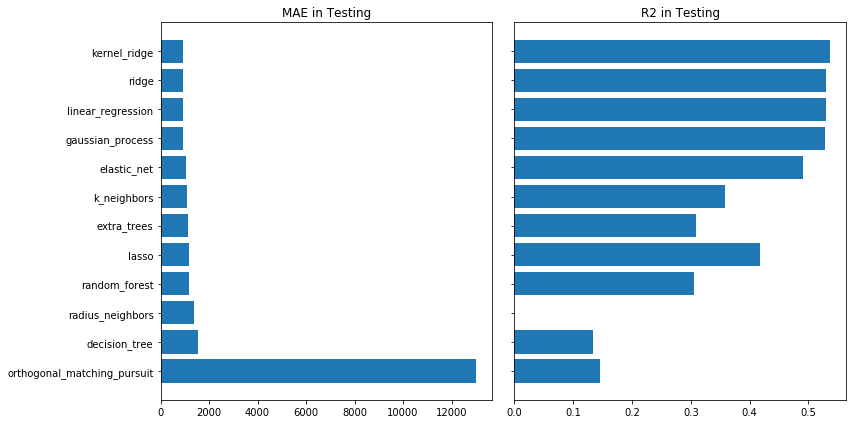

In [34]:
plot_training_summary(training_summary_document=training_summary)

Now it is the time to take a look at the actual results of the reconstruction.

We will start with sample 1.

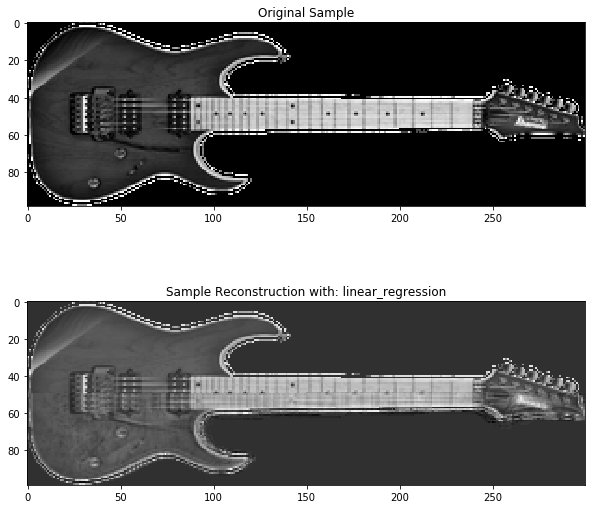

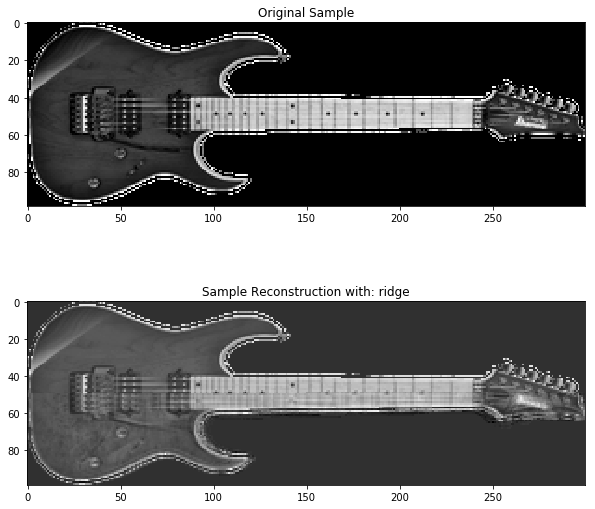

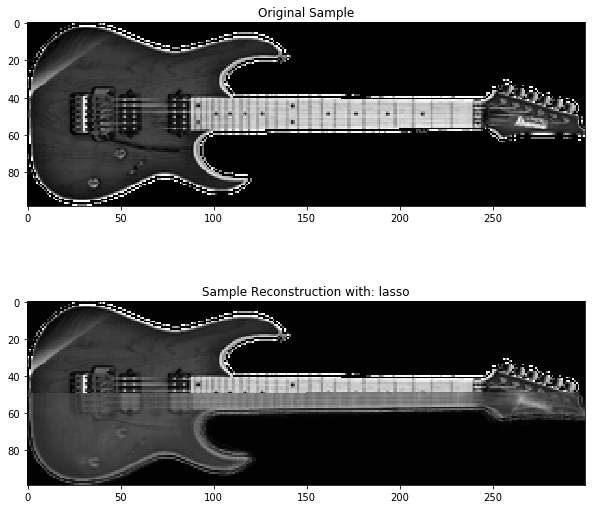

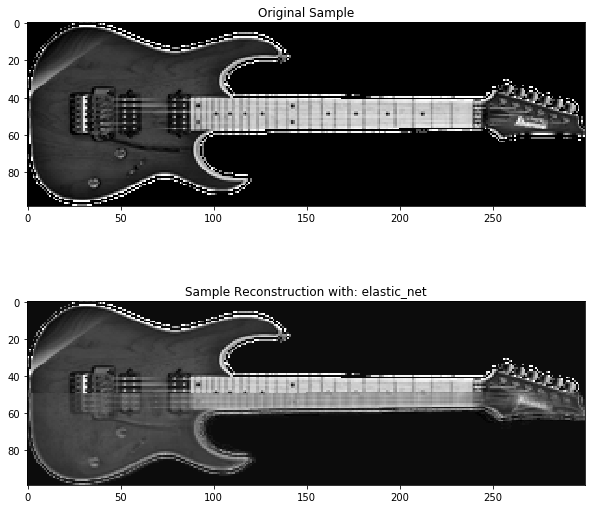

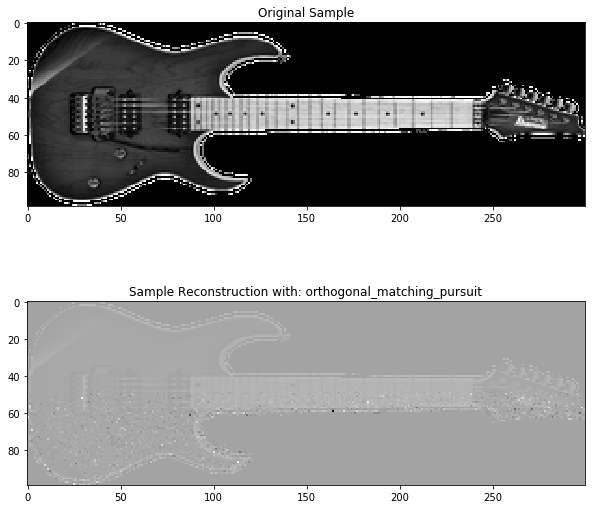

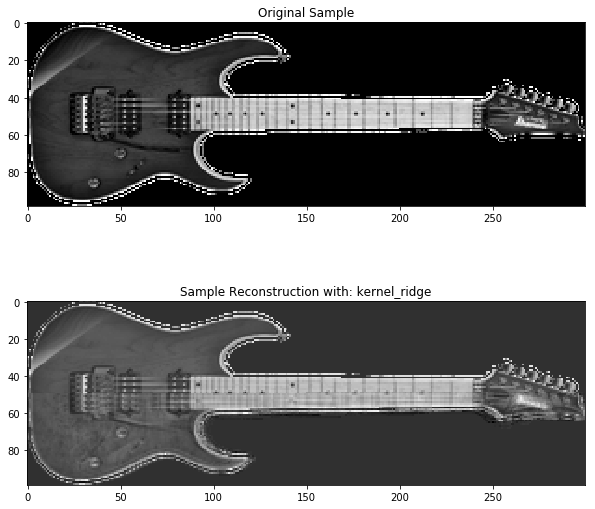

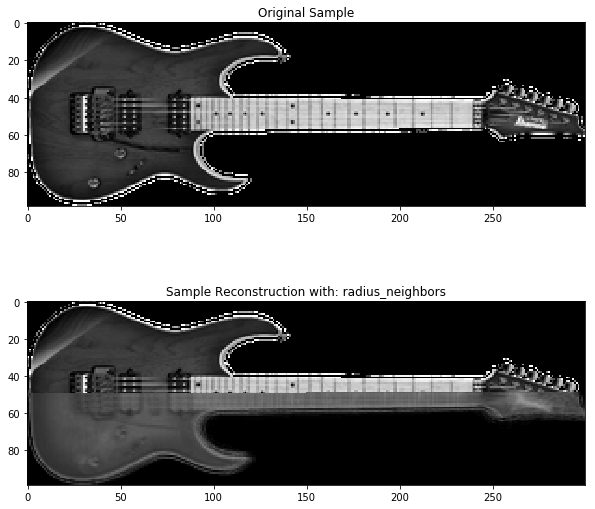

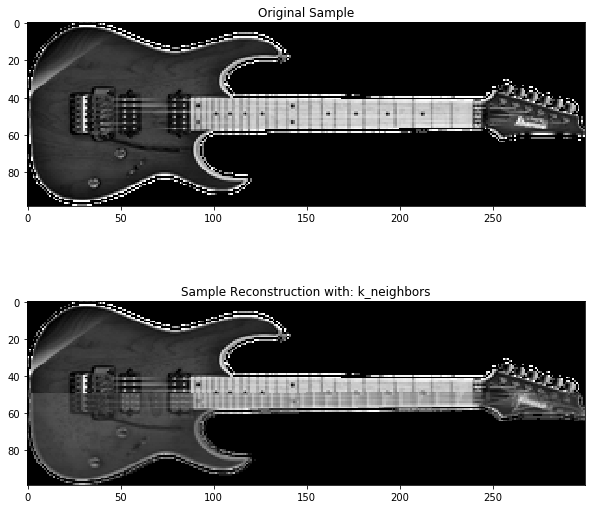

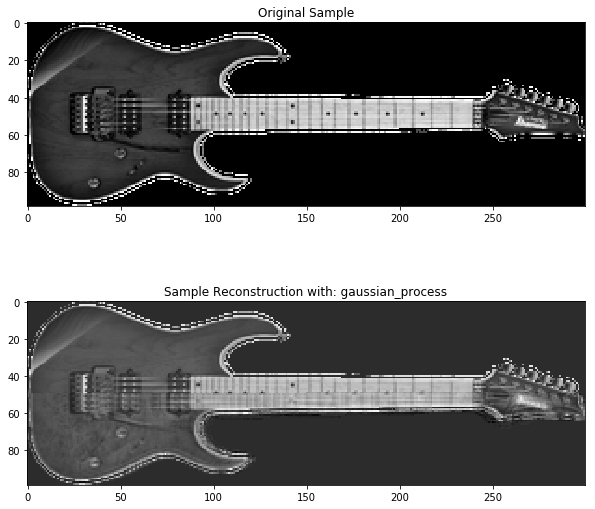

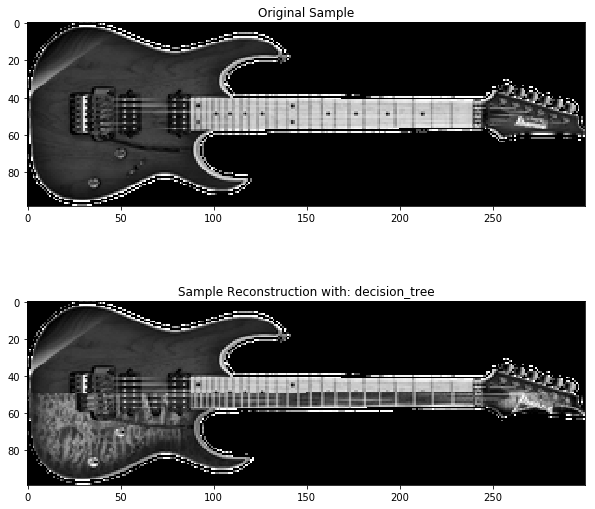

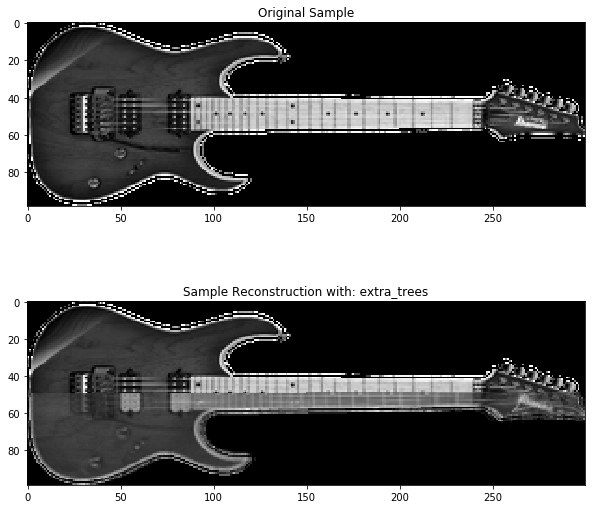

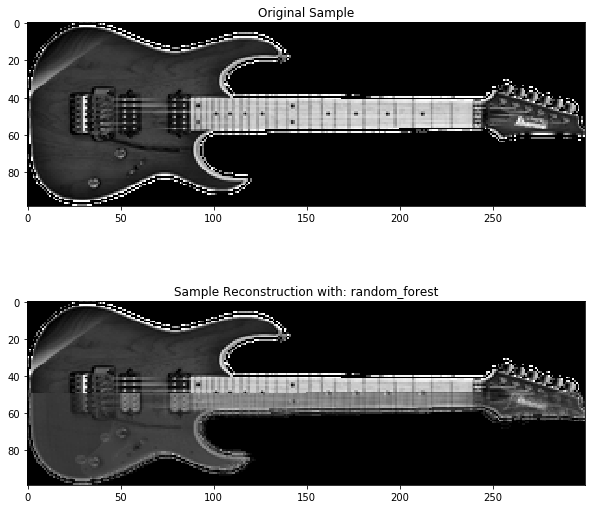

In [46]:
# Plot original vs. reconstruction for sample 1.
plot_original_vs_reconstruction(
    estimators=training_summary['estimator'].values,
    original_sample=testing_set[1, :],
    collection_of_reconstructions=extract_samples(
        summary=training_summary, sample=1
    )
)

This brings more context to the quantitative measurements of model performance. Ortoghonal matching pursuit seems not to be suitable model for this task, but all others show potential for further upgrading.

Let us see how models perform on structuraly different example.

c:\environments\standard_mkl_notebook\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


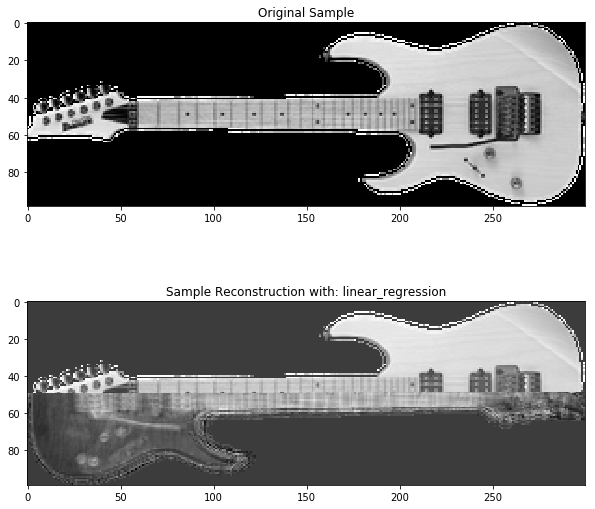

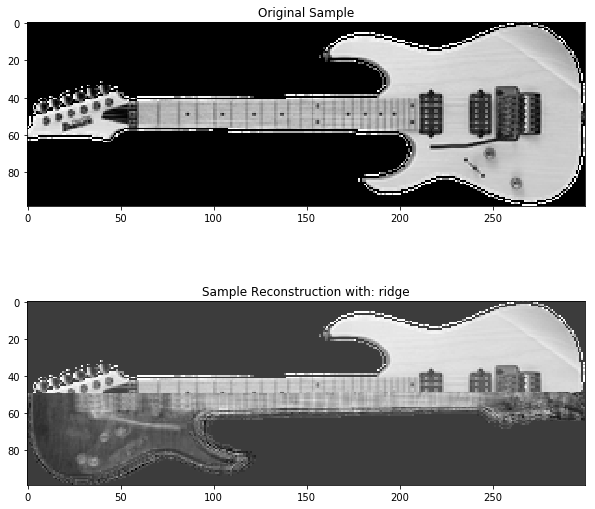

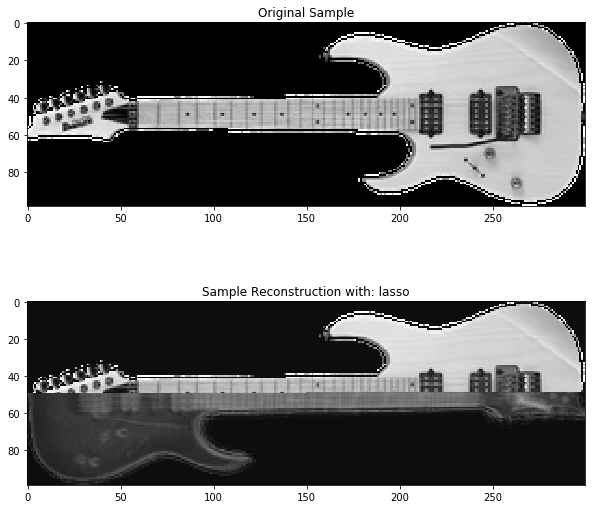

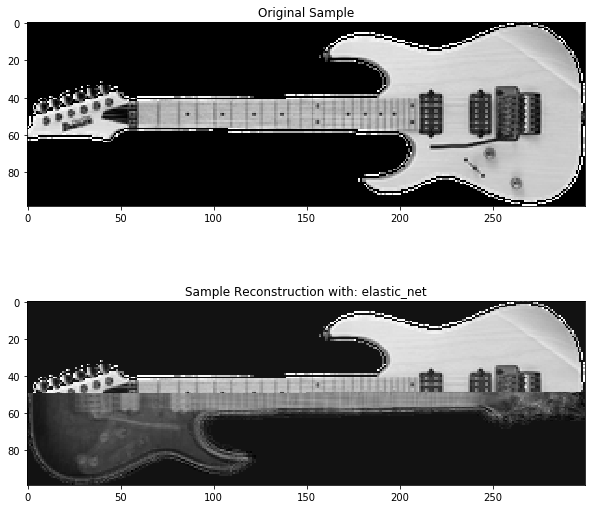

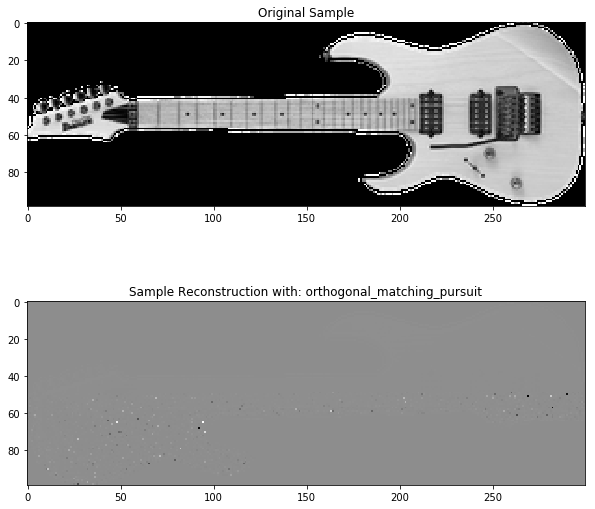

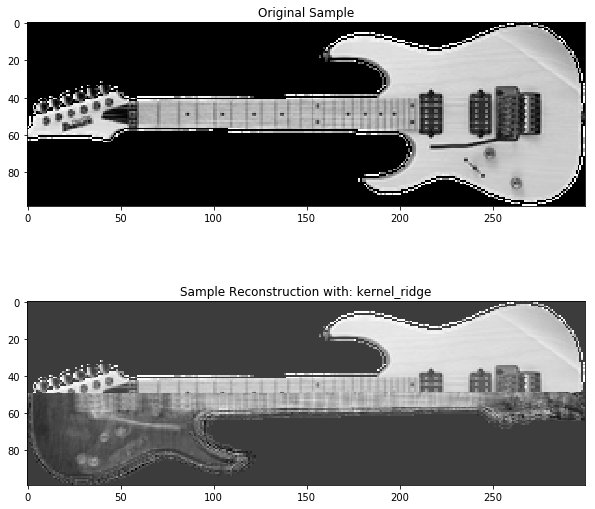

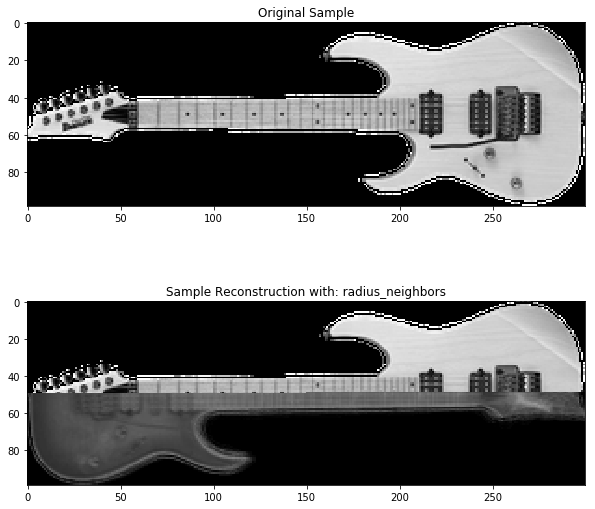

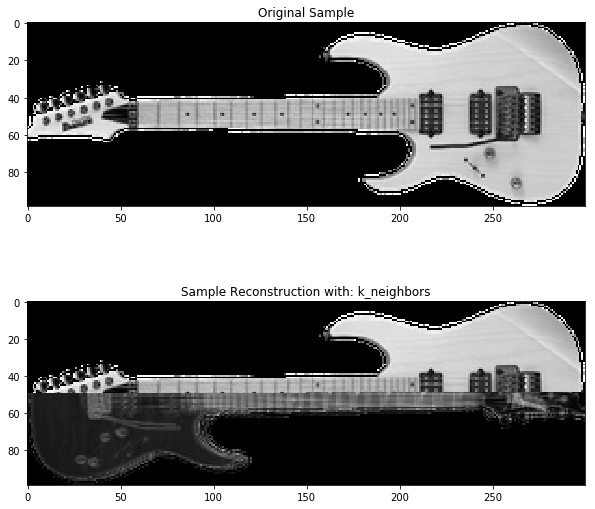

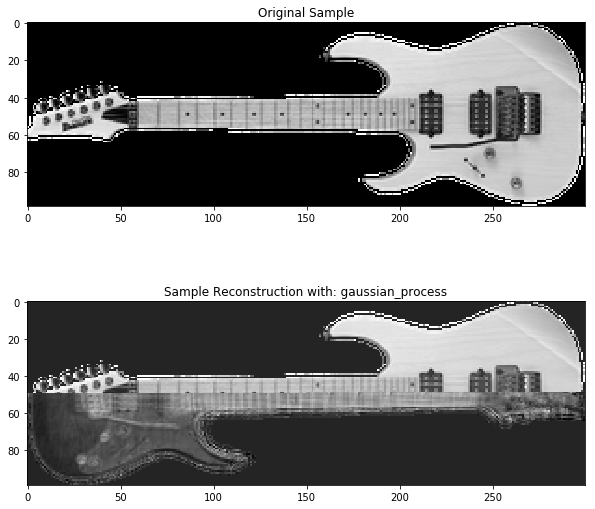

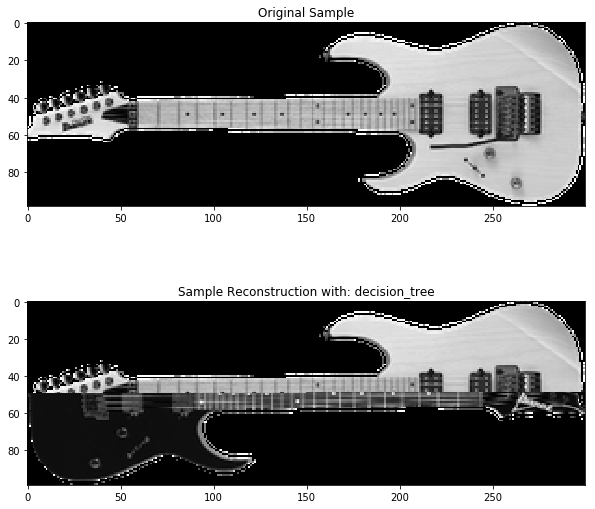

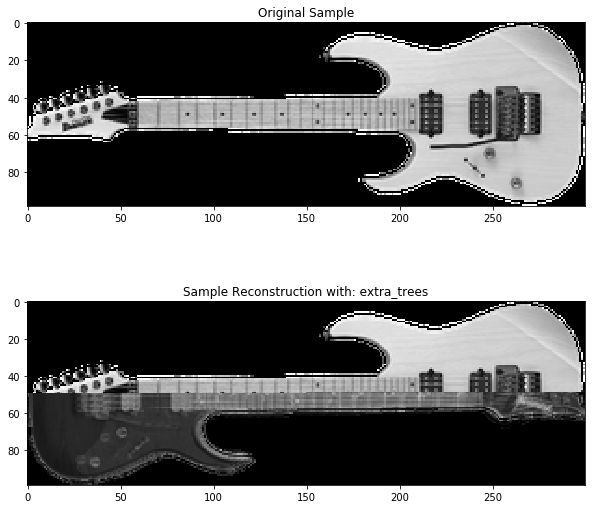

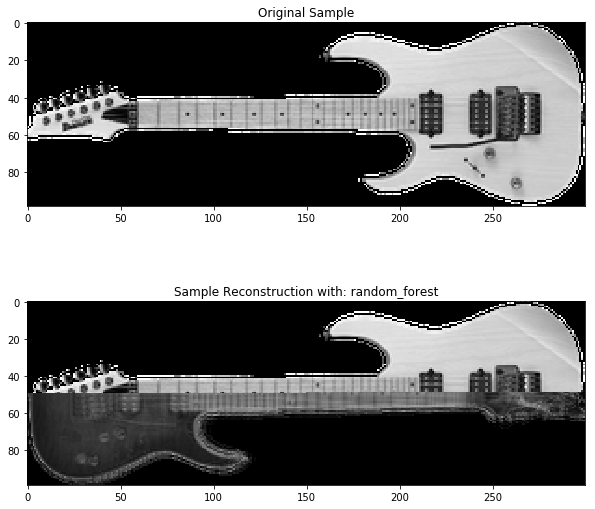

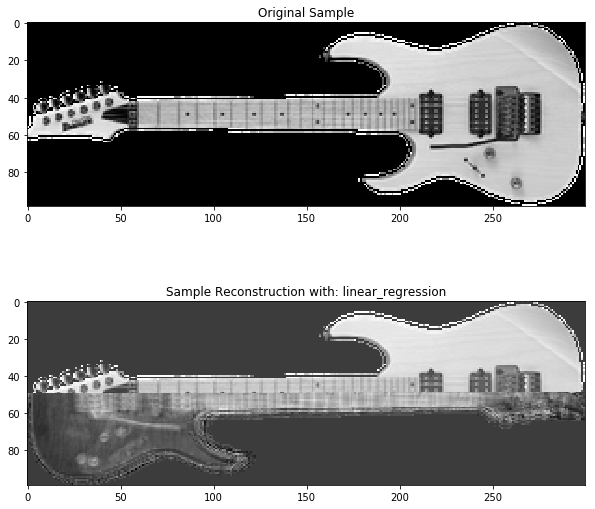

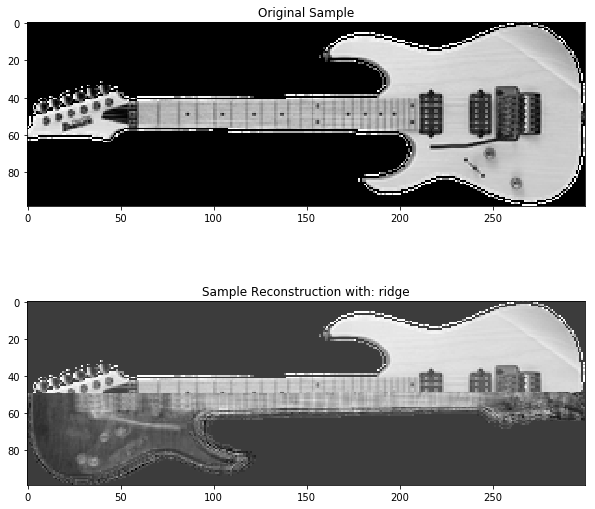

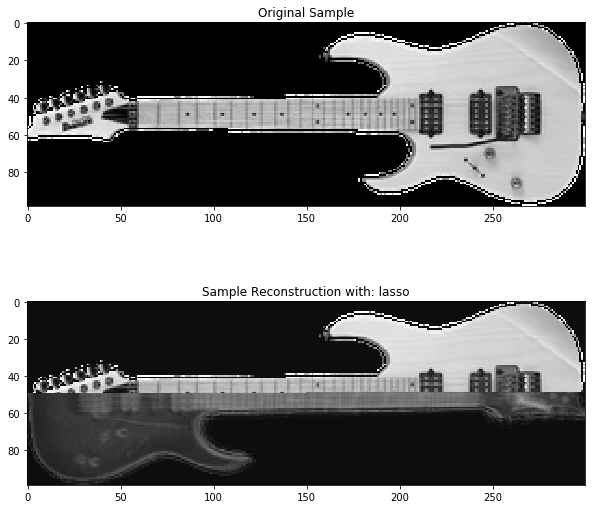

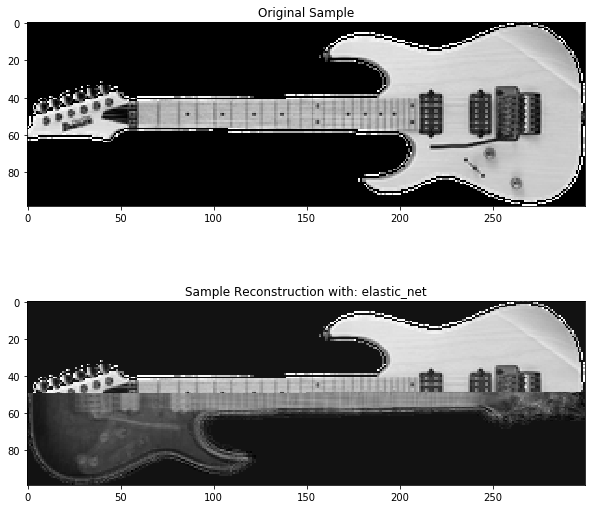

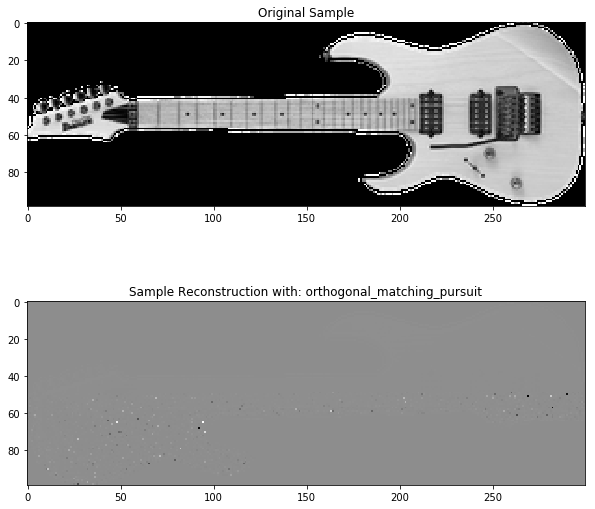

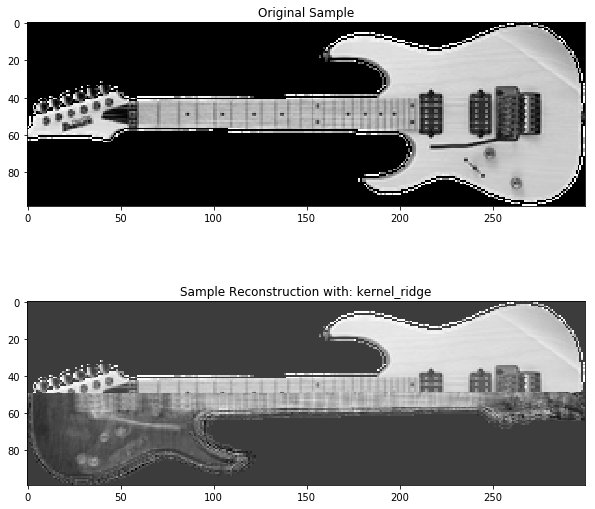

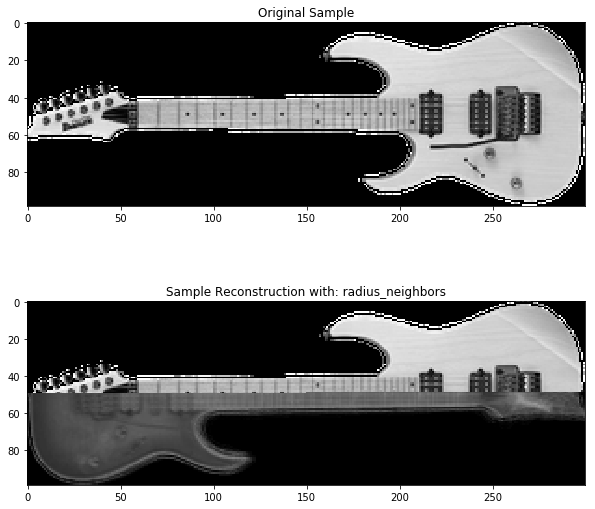

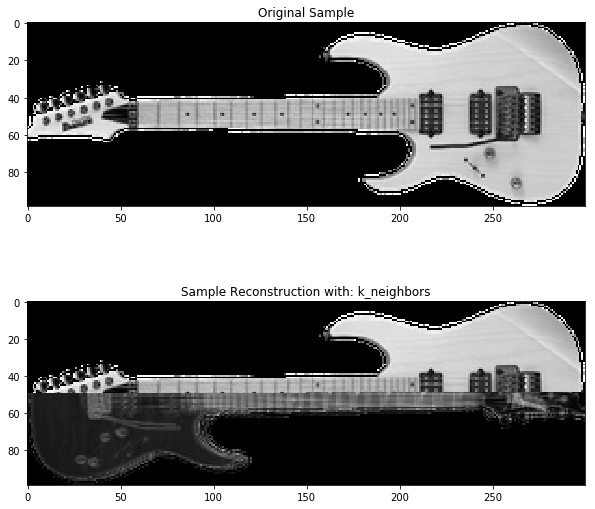

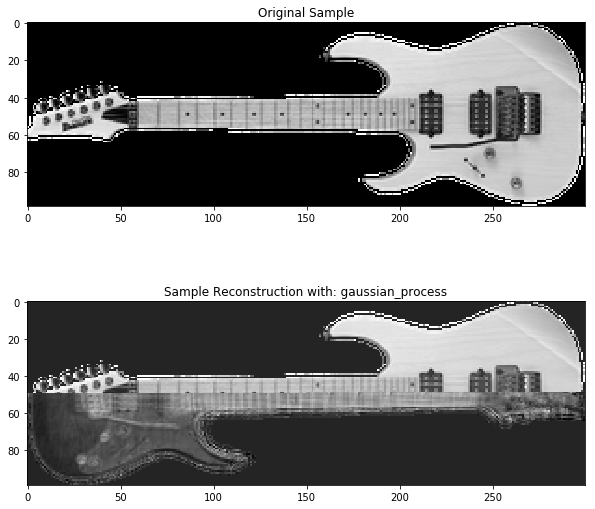

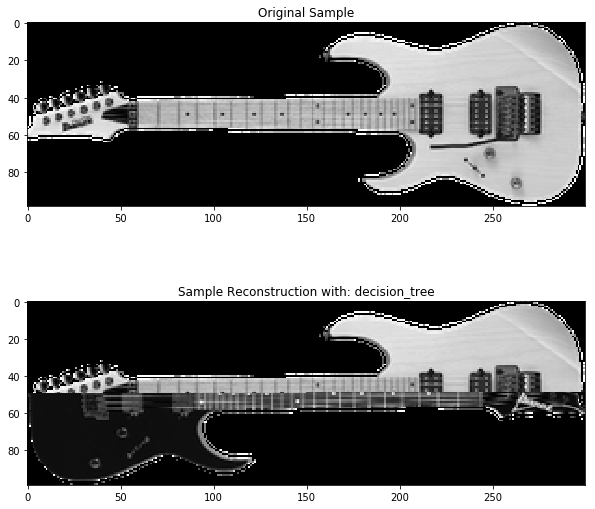

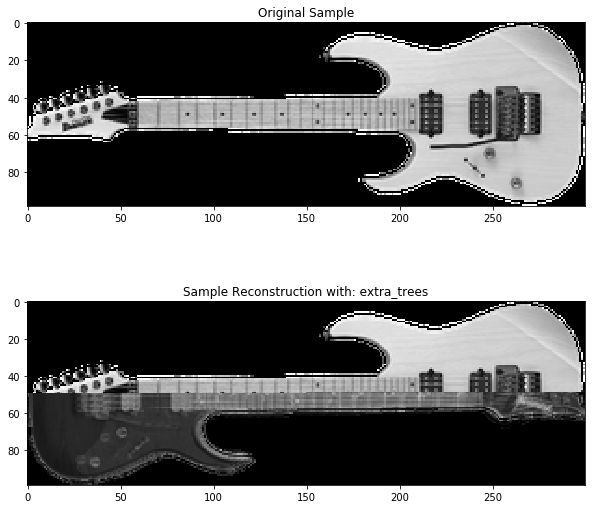

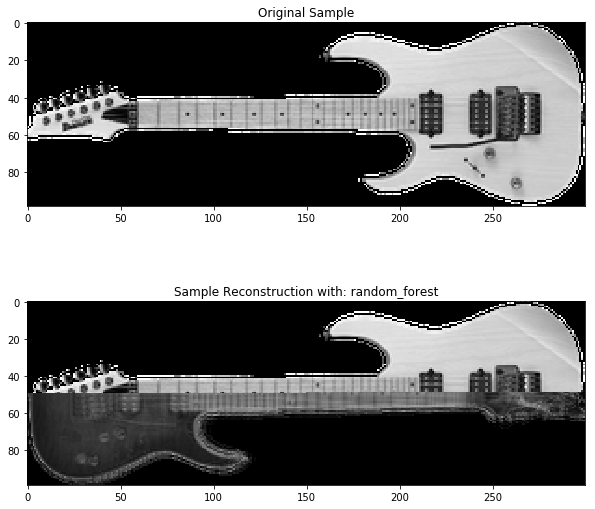

In [48]:
# Plot original vs. reconstruction for sample 12.
plot_original_vs_reconstruction(
    estimators=training_summary['estimator'].values,
    original_sample=testing_set[12, :],
    collection_of_reconstructions=extract_samples(
        summary=training_summary, sample=12
    )
)

All models fail when it comes to the structurally different example, and acctualy show that some degree of memorization is present, as opposed to more favorable generalization ability.

# Conclusion

This model training process has produced eleven valid solutions for the task of data reconstruction. Depending on the desired outcome, and both quantitative and qualitative evaluation of model performance, the most sutable solution for solving this task could be selected.

At the same time model training process has reveald some of the most common challenges of ML. One of them is that the models will generally converge towards the solution which gives them the least error, which ultimately defines their generalization ability. With the proper selection of training samples, and designig specific training processes for samples which are not predicted with desired degree of accuracy this issue can be resolved as well.